<a href="https://colab.research.google.com/github/ericyoc/gan_mc_sim_anomaly_detect_image/blob/main/gan_montecarlo_sim_anomaly_detect_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
# Define the generator model
def create_generator():
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(100,)),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(784, activation='tanh')
    ])
    return model

In [3]:

# Define the discriminator model
def create_discriminator():
    model = keras.Sequential([
        keras.layers.Dense(512, activation='relu', input_shape=(784,)),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [4]:
# Define the GAN model
def create_gan(generator, discriminator):
    discriminator.trainable = False
    model = keras.Sequential([generator, discriminator])
    return model

In [5]:
# Train the GAN
def train_gan(gan, generator, discriminator, x_train, batch_size, num_epochs):
    for epoch in range(num_epochs):
        # Generate random noise as input to the generator
        noise = np.random.normal(0, 1, (batch_size, 100))

        # Generate fake images using the generator
        generated_images = generator.predict(noise)

        # Combine real and fake images
        real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
        combined_images = np.concatenate([real_images, generated_images])

        # Create labels for real and fake images
        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
        labels += 0.05 * np.random.random(labels.shape)

        # Train the discriminator
        d_loss = discriminator.train_on_batch(combined_images, labels)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        misleading_targets = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, misleading_targets)

        # Print the progress
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")

In [6]:
# Perform anomaly detection using Monte Carlo simulation
def anomaly_detection(generator, discriminator, num_simulations):
    anomaly_scores = []
    for _ in range(num_simulations):
        noise = np.random.normal(0, 1, (1, 100))
        generated_image = generator.predict(noise)
        anomaly_score = discriminator.predict(generated_image)
        anomaly_scores.append(anomaly_score[0][0])
    return anomaly_scores

In [7]:
# Plot the test images and Monte Carlo simulation results
def plot_results(x_test, anomaly_scores, threshold):
    # Select an anomaly test image and a normal test image
    anomaly_image = x_test[np.argmin(anomaly_scores)]
    normal_image = x_test[np.argmax(anomaly_scores)]

    # Plot the anomaly test image
    plt.figure(figsize=(4, 4))
    plt.imshow(anomaly_image.reshape((28, 28)), cmap='gray')
    plt.title("Anomaly Test Image")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Plot the normal test image
    plt.figure(figsize=(4, 4))
    plt.imshow(normal_image.reshape((28, 28)), cmap='gray')
    plt.title("Normal Test Image")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Plot the Monte Carlo simulation results
    plt.figure(figsize=(8, 4))
    plt.hist(anomaly_scores, bins=20, density=True, alpha=0.7)
    plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
    plt.xlabel("Anomaly Score")
    plt.ylabel("Density")
    plt.title("Monte Carlo Simulation Results")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
# Print the results summary
def print_results_summary(anomaly_scores, threshold):
    print("Results Summary:")
    print(f"Threshold: {threshold:.4f}")
    print(f"Mean Anomaly Score: {np.mean(anomaly_scores):.4f}")
    print(f"Minimum Anomaly Score: {np.min(anomaly_scores):.4f}")
    print(f"Maximum Anomaly Score: {np.max(anomaly_scores):.4f}")
    print("Anomaly Score Interpretation:")
    print("- Anomaly scores below the threshold indicate anomalous samples.")
    print("- Anomaly scores above the threshold indicate normal samples.")

In [9]:

# Print the test image descriptions
def print_image_descriptions(y_test, anomaly_scores):
    anomaly_label = y_test[np.argmin(anomaly_scores)]
    normal_label = y_test[np.argmax(anomaly_scores)]
    print("Test Image Descriptions:")
    print(f"Anomaly Test Image: Digit {anomaly_label}")
    print(f"Normal Test Image: Digit {normal_label}")

In [10]:
def main():
    # Load and preprocess the MNIST dataset
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    x_train = x_train.reshape((60000, 784)) / 255.0
    x_test = x_test.reshape((10000, 784)) / 255.0

    # Create the generator, discriminator, and GAN models
    generator = create_generator()
    discriminator = create_discriminator()
    gan = create_gan(generator, discriminator)

    # Compile the models
    with tf.device('/gpu:0'):  # Use GPU for training
        discriminator.compile(optimizer='adam', loss='binary_crossentropy')
        gan.compile(optimizer='adam', loss='binary_crossentropy')

        # Train the GAN
        batch_size = 128
        num_epochs = 100
        train_gan(gan, generator, discriminator, x_train, batch_size, num_epochs)

    # Perform anomaly detection using Monte Carlo simulation
    num_simulations = 1000
    anomaly_scores = anomaly_detection(generator, discriminator, num_simulations)

    # Calculate the threshold for anomaly detection
    threshold = np.percentile(anomaly_scores, 95)

    # Plot the test images and Monte Carlo simulation results
    plot_results(x_test, anomaly_scores, threshold)

    # Print the results summary
    print_results_summary(anomaly_scores, threshold)

    # Print the test image descriptions
    print_image_descriptions(y_test, anomaly_scores)


4/4 [==============================] - 0s 3ms/step
Epoch: 0, Discriminator Loss: 0.7730990052223206, Generator Loss: 0.6322225332260132
4/4 [==============================] - 0s 2ms/step
Epoch: 10, Discriminator Loss: 5.377053260803223, Generator Loss: 3.9765633118804544e-05
4/4 [==============================] - 0s 2ms/step
Epoch: 20, Discriminator Loss: 6.210137367248535, Generator Loss: 6.786923222534824e-06
4/4 [==============================] - 0s 2ms/step
Epoch: 30, Discriminator Loss: 6.307380676269531, Generator Loss: 5.354259883461054e-06
4/4 [==============================] - 0s 2ms/step
Epoch: 40, Discriminator Loss: 6.347647666931152, Generator Loss: 4.9400332500226796e-06
4/4 [==============================] - 0s 2ms/step
Epoch: 50, Discriminator Loss: 6.359194278717041, Generator Loss: 4.858706233790144e-06
4/4 [==============================] - 0s 2ms/step
Epoch: 60, Discriminator Loss: 6.36337423324585, Generator Loss: 4.789210379385622e-06
4/4 [========================

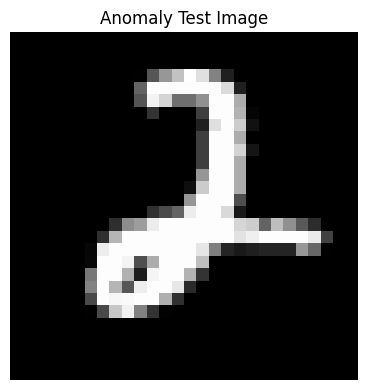

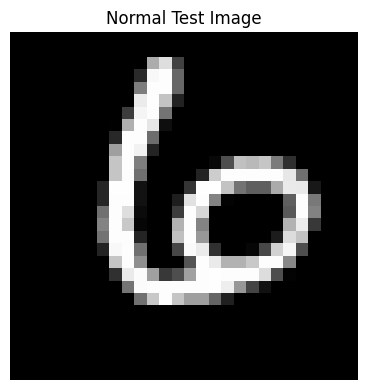

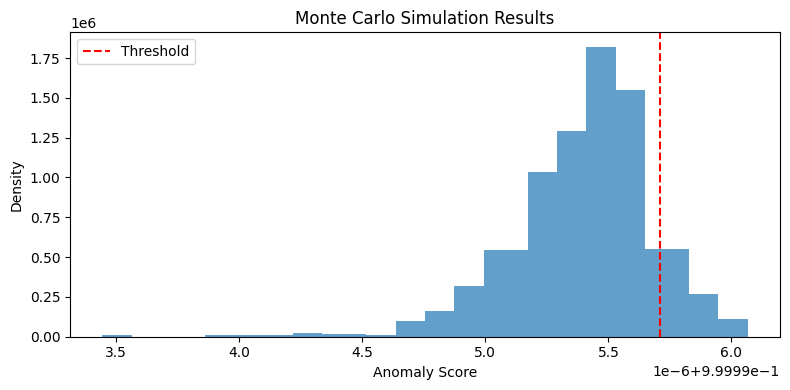

Results Summary:
Threshold: 1.0000
Mean Anomaly Score: 1.0000
Minimum Anomaly Score: 1.0000
Maximum Anomaly Score: 1.0000
Anomaly Score Interpretation:
- Anomaly scores below the threshold indicate anomalous samples.
- Anomaly scores above the threshold indicate normal samples.
Test Image Descriptions:
Anomaly Test Image: Digit 2
Normal Test Image: Digit 6


In [11]:
if __name__ == '__main__':
    main()